<h1><center><b><u>Credit Risk Modelling</u></b></center></h1>
This Notebook make use of the findings of Credit_risk_assements_analysis notebook & develop a credit risk classification model.<br>
Steps involved:-
<ul>
    <li>Data Preparation where we perform all the processing steps explained in analysis notebook</li>
    <li>Splitting Data into train & test for modelling</li>
    <li>Model Selection & Parameter tunning using gridSearchCV</li>
    <li>Use the best estimator & train it on training dataset</li>
    <li>Get the f1_score & Confusion Matrix on the test dataset</li>
</ul>
</br>
<b>Note :- </b> 
<ul>
    <li>Distribution of data between Default & No Default is <b>imbalanced</b> so to overcome that <b>class weight balancer technique</b> is used, where we assign weights to each class based on their ratios.</li>
    <li>For performance Evaluation <b>f1_score</b> is being used as this scores consider both precision & recall for validating model. Based on business requirements this metric can be changed based on the crticality of Default / No Default classification</li>
    <li>In this we transformed continuos variables into categoricla variables by creating ban0ds (Ex:- Cibil_score from 0-600 will be replaced by band_1 & so on) of different bins size. Identification of this bins is being done usinf Weight of Evidence method in analysis notebook</li>
    <li> Advantage of converting continuos variables into bands helps us in handling outliers, as extreme outliers will be merged with the nearest valid values while creation of groups</li> 
    <li> Example for band :- [-1.0, 665.0, 705.0, 858.0] so in this values from -1 to 665 all comes in one group named as band_1, similarly for 666 to 705 will come in band_2 & so on</li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import pandasql as ps
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

G:\Anaconda\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
random_seed = 21
np.random.seed(random_seed)

<h2><b><u><center>Data Processing

<h3> Loans data processing </h3>
Selection of variables based on the outcome of Credit risk assessments analysis notebook

In [3]:
raw_loans = pd.read_csv("data_loans_5k.csv",parse_dates=["disbursed_at"])

In [4]:
loans_column_selected = ["master_user_id",
                         "max_dpd",
                         "is_non_starter",
                         "amount",
                         "disbursed_at",
                         "period"
                        ]

In [5]:
default_df = raw_loans[loans_column_selected].copy()

In [6]:
default_df["target"] = np.where(default_df["max_dpd"] > 30, "Default", "No Default")
default_df.drop("max_dpd", axis=1, inplace=True)

<h4>Below section will create two columns in loans dataframe</h4>
<ul>
    <li><b>past_default_count :- </b> This columns stores the information that how many time user has defaulted in past before applying for this loan.</li>
        <li><b>total_past_records :- </b> This columns stores the information about the user that for how many times he has applied for loans & get approved before this particular loan application disbursed.</li>
</ul>

In [7]:
sql_code = """
select A.*,
    CASE
        WHEN B.target = "Default" THEN 1
        ELSE 0
    END as past_default_count,
    CASE
        WHEN B.master_user_id is NOT NULL THEN 1
        ELSE 0
    END as total_past_records
from default_df as A
left join default_df as B
on A.master_user_id = B.master_user_id
and A.disbursed_at > B.disbursed_at
"""
intermediate_df = ps.sqldf(sql_code,locals())

def aggregator(df):
    result = df.iloc[0]
    result["past_default_count"] = sum(df.past_default_count)
    result["total_past_records"] = sum(df.total_past_records) + 1
    return result

processed_loan_df = intermediate_df.groupby(["master_user_id",
                                             "disbursed_at"]).\
                                    apply(aggregator).\
                                    reset_index(drop=True)
del(intermediate_df)

In [8]:
processed_loan_df.head(2)

,master_user_id,is_non_starter,amount,disbursed_at,period,target,past_default_count,total_past_records
0,1,0,10000.0,2016-02-15 14:42:10.038000,3,No Default,0,1
1,1,0,9000.0,2016-06-27 00:00:00.000000,3,No Default,0,2


<h3> Assessments data processing </h3>
Selection of variables based on the outcome of Credit risk assessments analysis notebook

In [9]:
raw_assessments = pd.read_csv("data_assessments_5k.csv", parse_dates=["created_at"])

In [10]:
assessment_column_selected = ["master_user_id",
                              "created_at",
                              "reason_premium",
                              "reason_flexi",
                              "cibil_score",
                              "stated_income",
                              "line_amount",
                              "product_type"
                             ]

In [11]:
processed_assessments = raw_assessments[assessment_column_selected].copy()

In [12]:
del(raw_assessments)

<h3>Join both Loan data & Assessments data</h3>
Join Condition: -
<ul>
    <li>master_user_id</li>
    <li>loans.disbursed_at > assessment.created_at</li>
    <li>Keep only the latest assessments which decided the loans approval decision</li>
</ul>
<b>Note: -</b> Reason behind removing all the assessments & keeping only the latest one is to get the assessment on which that loan is approved. as this is where we have to look what we can improve in our model to classify defaulters better

In [13]:
columns = [col for col in processed_assessments.columns if col !="master_user_id"]
column_string = "B." +", B.".join(columns)

In [14]:
sql_join = f"""
SELECT A.*,
    {column_string}
from processed_loan_df as A
left join processed_assessments as B
on A.master_user_id = B.master_user_id
    and A.disbursed_at > B.created_at
"""
joined_intermediate_df = ps.sqldf(sql_join, locals())

In [15]:
joined_intermediate_df = joined_intermediate_df.sort_values(by=["master_user_id", "created_at"])
joined_data = joined_intermediate_df.groupby(list(processed_loan_df.columns)).tail(1)
del(joined_intermediate_df)

# Drop xxetra columns which is not required in modelling
joined_data.drop(["master_user_id", "disbursed_at", "created_at"], axis=1, inplace=True)

<h3><b><u><center>Preprocessing</center></u></b></h3>
<ul>
    <li>Imputation of missing values.</li>
    <li>Based on bins computed using weight of evidence in analysis notebook create bands in data.</li>
    <li>Creation of dummy variables</li>
</ul>

<h4>Preprocessing helper functions</h4>

In [16]:
mode_dict = {}

def train_missing_value_handler(x):
    """
        input:- train dataframe
        output :- dataframe with imputed values based on their mode
    """
    global mode_dict
    for column in x.columns:
        mode_dict[column] = x[column].mode()[0]
        x[column].fillna(mode_dict[column], inplace=True)
    return x

def test_missing_value_handler(x):
    """
        input:- test dataframe
        output :- dataframe with imputed values based on train dataframe mode
    """
    for column in x.columns:
        x[column].fillna(mode_dict[column], inplace=True)
    return x

In [17]:
# Bins Info variables to be used in creation of bands in train & test data

past_default_count_bins = [0.0, 1.0, 2.0, 3.0]
past_default_count_band = [str(i) for i in range(1,
                                                 len(past_default_count_bins))]

period_bins = [3.0, 6.0, 9.0, 24.0]
period_band = [str(i) for i in range(1,
                                     len(period_bins))]

amount_bins = [4500.0, 15000.0, 30000.0, 50000.0, 200000.0]
amount_band = [str(i) for i in range(1,
                                     len(amount_bins))]

stated_income_bins = [0.0, 19000.0, 24500.0, 32500.0, 300000.0]
stated_income_band = [str(i) for i in range(1,
                                            len(stated_income_bins))]

line_amount_bins = [10000.0, 35000.0, 50000.0, 200000.0]
line_amount_band = [str(i) for i in range(1,
                                          len(line_amount_bins))]

total_past_records_bins = [0.0, 1.0, 6.0]
total_past_records_band = [str(i) for i in range(1,
                                                 len(total_past_records_bins))]

cibil_score_bins = [-1.0, 665.0, 705.0, 858.0]
cibil_score_band = [str(i) for i in range(1,
                                          len(cibil_score_bins))]


band_dict = {}
band_dict["past_default_count"] = [past_default_count_band,
                                   past_default_count_bins]
band_dict["period"] = [period_band, period_bins]
band_dict["amount"] = [amount_band, amount_bins]
band_dict["stated_income"] = [stated_income_band, stated_income_bins]
band_dict["line_amount"] = [line_amount_band, line_amount_bins]
band_dict["total_past_records"] = [total_past_records_band,
                                   total_past_records_bins]
band_dict["cibil_score"] = [cibil_score_band, cibil_score_bins]

In [18]:
def band_assigner(x):
    """
        Responsible of conversion of bins to there respective band category
        input :- dataframe
        output:- dataframe with continuos variable converted into categorical features based on there bands label.
    """
    global band_dict
    
    for col in band_dict.keys():
        col_labels = band_dict[col][0]
        col_bins = band_dict[col][1]
        x[col+"_band"] = pd.cut(x[col],
                                bins=col_bins,
                                labels=col_labels,
                                include_lowest=True)
        x.drop(col, axis=1, inplace=True)
    return x

In [19]:
train_columns = []

def dummy_creator(df, columns=[], data_type="train"):
    """
        Creation of dummy columns based on their categorical values
        input :-
            df :- dataframe for which dummy variables has to be created
            columns :- list of columns for which dummy creation is required
                default = []
            data_type :- {"train", "test"}
                info = based on train/test it makes sure that the training & test data has same set of columns
                default = "train"
        output :- 
            returns DataFrame with dummy columns created
    """
    
    global train_columns
    
    if len(columns) == 0:
        df_dummy = pd.get_dummies(df,
                                  columns=df.columns,
                                 )
    else:
        df_dummy = pd.get_dummies(df,
                                  columns=columns,
                                 )
    
    if data_type == "train":
        train_columns = df_dummy.columns
    else:
        for column in train_columns:
            if column not in df_dummy.columns:
                df_dummy[column] = 0
    
    return df_dummy[train_columns]

<h3>Train Test Split</h3>
Split data into train & Test

In [20]:
y = np.where(joined_data.target == "No Default", 0, 1)
X = joined_data.drop("target", axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [22]:
# Removes NA values from Train & Test
X_train_na_removed = train_missing_value_handler(X_train.copy())
X_test_na_removed = test_missing_value_handler(X_test.copy())

In [23]:
# Conversion of continuos variables into categorical variables using band transformation
X_train_grouped = band_assigner(X_train_na_removed.copy())
X_test_grouped = band_assigner(X_test_na_removed.copy())

In [24]:
# Creation of dummy variables in train & test fro categorical columns
X_train_dummy = dummy_creator(X_train_grouped, data_type="train")
X_test_dummy = dummy_creator(X_test_grouped, data_type="test")

<h2><b><u><center>Modelling</u></b></h2>

<h3>Model Selection with parameter tunning</h3>
Models tried :-
<ul>
    <li>Logistic Regression</li>
    <li>Random Forest Classifier</li>
    <li>KNeighbour Classifier</li>
    <li>XGB Classifier</li>
</ul>

In [25]:
"""
Custom Scoring Function for f1_score
"""
my_scorer = make_scorer(f1_score, greater_is_better=True)

<h4>Logistic Regression

In [26]:
# Parameter space for Logistic Regression

C = np.logspace(0, 4, 3)
penalty = ['l2']
class_weight = [{0: 0.71, 1: 1.68}, {0: 1, 1: 3}]
max_iter = np.arange(900, 1000, 100)

hyperparameters = dict(C=C,
                       penalty=penalty,
                       max_iter=max_iter,
                       class_weight=class_weight,
                       random_state=[random_seed]
                      )

In [27]:
model = LogisticRegression()
logistic_search_cv = GridSearchCV(model,
                                  hyperparameters,
                                  cv=5,
                                  scoring=my_scorer,
                                  verbose=0)
best_logistic_model = logistic_search_cv.fit(X_train_dummy, y_train).best_estimator_

In [28]:
print("Best Score of Logistic regression :- ", logistic_search_cv.best_score_)
print("Best params :- ", logistic_search_cv.best_params_)

Best Score of Logistic regression :-  0.45348814463525383
Best params :-  {'C': 1.0, 'class_weight': {0: 1, 1: 3}, 'max_iter': 900, 'penalty': 'l2', 'random_state': 21}


<h4>Random Forest Classifier

In [29]:
n_estimators = [50, 100, 200, 300, 400]
class_weight = [{0: 0.71, 1: 1.68}, {0: 1, 1: 3}]
max_features = ["sqrt", "log2"]
hyperparameters = {"n_estimators": n_estimators,
                   "criterion": ["entropy"],
                   "class_weight": class_weight,
                   "max_features":max_features,
                   "random_state":[random_seed]
                  }

In [30]:
model = RandomForestClassifier()
rf_search_cv = GridSearchCV(model,
                            hyperparameters,
                            cv=5,
                            scoring=my_scorer,
                            verbose=0)
best_rf_model = rf_search_cv.fit(X_train_dummy, y_train).best_estimator_

In [31]:
print("Best Score of Random Forest classifier :- ", rf_search_cv.best_score_)
print("Best params :- ", rf_search_cv.best_params_)

Best Score of Random Forest classifier :-  0.47096479961522614
Best params :-  {'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 400, 'random_state': 21}


<h4>KNeighbour Classifier

In [32]:
n_neighbors = [4, 5, 6, 7, 8, 9, 10]
hyperparameters = {"n_neighbors": n_neighbors,
                   "weights": ["uniform", "distance"]
                  }

In [33]:
model = KNeighborsClassifier()
knn_search_cv = GridSearchCV(model,
                            hyperparameters,
                            cv=5,
                            scoring=my_scorer,
                            verbose=0)
best_knn_model = knn_search_cv.fit(X_train_dummy, y_train).best_estimator_

In [34]:
print("Best Score of KNN :- ", knn_search_cv.best_score_)
print("Best params :- ", knn_search_cv.best_params_)

Best Score of KNN :-  0.3385746169750867
Best params :-  {'n_neighbors': 5, 'weights': 'distance'}


<h4> XGB Classifier

In [35]:
max_depth = [5, 6, 7]
min_child_weight = [4, 5, 6]
n_estimators = [300, 400, 500]

hyperparameters = {"n_estimators": n_estimators,
                   "max_depth": max_depth,
                   "min_child_weight": min_child_weight,
                   "random_state":[random_seed]
                  }

In [36]:
model = XGBClassifier()
xgb_search_cv = GridSearchCV(model,
                            hyperparameters,
                            cv=5,
                            scoring=my_scorer,
                            verbose=0)
best_xgb_model = xgb_search_cv.fit(X_train_dummy, y_train).best_estimator_

In [37]:
print("Best Score of XGB Classifier :- ", xgb_search_cv.best_score_)
print("Best params :- ", xgb_search_cv.best_params_)

Best Score of XGB Classifier :-  0.28642346379354783
Best params :-  {'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 500, 'random_state': 21}


<h2><b><u><center> Final Model </center></u></b></h2>
Based on all models score RandomForestClassifier is performing well. So we will use it as Final Model for Classification Test dataset 

In [38]:
best_rf_model.fit(X_train_dummy, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 3}, criterion='entropy',
                       max_features='log2', n_estimators=400, random_state=21)

In [39]:
y_pred = best_rf_model.predict(X_test_dummy)
score = f1_score(y_test, y_pred)
print("Model f1_score :- ", score)

Model f1_score :-  0.4495867768595041


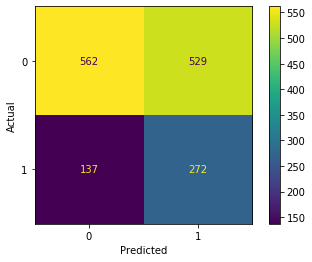

In [47]:
plot_confusion_matrix(best_rf_model, X_test_dummy, y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
